# Generating clustered state

In [1]:
import numpy as np
from scipy.stats import unitary_group
from opt_einsum import contract
import torch

from src.QDDPM_torch import DiffusionModel, QDDPM, naturalDistance

import time

import matplotlib.pyplot as plt
from matplotlib import rc
rc('text', usetex=True)
rc('axes', linewidth=3)

## data set generation

In [2]:
def cluster0Gen(n, N_train, scale, seed=None):
    '''
    generate random quantum states close to |0...0>
    Args:
    n: number of qubits
    N_train: number of data to generate
    scale: the scaling factor on amplitudes except |0...0>
    seed: control the randomness
    '''
    np.random.seed(seed)
    # amplitude for basis except |0...0>
    remains = np.random.randn(N_train,2**n-1)+1j*np.random.randn(N_train,2**n-1) 
    states = np.hstack((np.ones((N_train,1)), scale*remains)) # un-normalized
    states /= np.tile(np.linalg.norm(states, axis=1).reshape((1, N_train)), (2**n, 1)).T
    return states.astype(np.complex64)

# 1-qubit cluster problem

## Generate diffusion data

In [ ]:
# generate dfifusion data set
n = 1
T = 20
Ndata = 1000

diff_hs = np.linspace(1., 4., T)
diff_hs = torch.from_numpy(diff_hs)

model_diff = DiffusionModel(n, T, Ndata)
X = torch.from_numpy(cluster0Gen(1, Ndata, 0.08, seed=12))
Xout = np.zeros((T+1, Ndata, 2**n), dtype=np.complex64)
Xout[0] = X.numpy()
for t in range(1, T+1):
    Xout[t] = model_diff.set_diffusionData_t(t, X, diff_hs[:t], seed=t).numpy()

visulaize the decay of fidelity

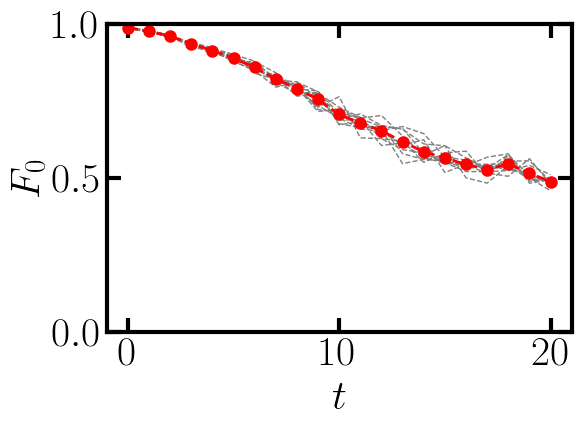

In [12]:
# visualize the fidelity decay in the diffusion process
n = 1
T = 20
N = 1000
states_diff = np.load('data/cluster/n%d/cluster0Diff_n%dT%d_N%d.npy'%(n, n, T, N))
fig, ax = plt.subplots(figsize=(6, 4))
indices = np.random.permutation(1000)
for i in range(10):
    ax.plot(range(T+1), np.mean(np.abs(states_diff[:, indices[100*i:100*(i+1)], 0])**2, axis=1),
            '--', lw=1, c='grey')
ax.plot(range(T+1), np.mean(np.abs(states_diff[:,:,0])**2, axis=1), 'o--', markersize=8, lw=2, c='r')
ax.set_ylabel(r'$F_0$', fontsize=30)
ax.set_xlabel(r'$t$', fontsize=30)
ax.set_ylim(0,1)
ax.tick_params(direction='in', length=10, width=3, top='on', right='on', labelsize=30)

## Training QDDPM

In [24]:
def Training_t(model, t, inputs_T, params_tot, Ndata, epochs):
    '''
    the trianing for the backward PQC at step t
    input_tplus1: the output from step t+1, as the role of input at step t
    Args:
    model: the QDDPM model
    t: the diffusion step
    inputs_T: the input data at step t=T
    params_tot: collection of PQC parameters before step t
    Ndata: number of samples in dataset
    epochs: the number of iterations
    '''
    input_tplus1 = model.prepareInput_t(inputs_T, params_tot, t, Ndata) # prepare input
    states_diff = model.states_diff
    loss_hist = [] # record of training history

    # initialize parameters
    np.random.seed()
    params_t = torch.tensor(np.random.normal(size=2 * model.n_tot * model.L), requires_grad=True)
    # set optimizer and learning rate decay
    optimizer = torch.optim.Adam([params_t], lr=0.0005)
    
    t0 = time.time()
    for step in range(epochs):
        indices = np.random.choice(states_diff.shape[1], size=Ndata, replace=False)
        true_data = states_diff[t, indices]

        output_t = model.backwardOutput_t(input_tplus1, params_t)
        loss = naturalDistance(output_t, true_data)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_hist.append(loss) # record the current loss
        
        if step%100 == 0:
            loss_value = loss_hist[-1]
            print("Step %s, loss: %s, time elapsed: %s seconds"%(step, loss_value, time.time() - t0))

    return params_t, torch.stack(loss_hist)

In [ ]:
# denoise training

n, na = 1, 1 # number of data and ancilla qubits
T = 20 # number of diffusion steps
L = 4 # layer of backward PQC
Ndata = 100 # number of data in the training data set
epochs = 2001 # number of training epochs

# generate random samples at step t=T
diffModel = DiffusionModel(n, T, Ndata)
inputs_T = diffModel.HaarSampleGeneration(Ndata, seed=22)

# load diffusion process
states_diff = np.load('data/cluster/n1/cluster0Diff_n1T20_N1000.npy')
model = QDDPM(n=n, na=na, T=T, L=L)
model.set_diffusionSet(states_diff)

for t in range(T-1, -1, -1):
    params_tot = np.zeros((T, 2*(n+na)*L))
    for tt in range(t+1, 20):
        params_tot[tt] = np.load('data/cluster/n1/QDDPMcluster0params_n1na1T20L4_t%d_mmd.npy'%tt)
    params, loss_hist = Training_t(model, t, inputs_T, params_tot, Ndata, epochs)
    
    np.save('data/cluster/n1/QDDPMcluster0params_n1na1T20L4_t%d_mmd.npy'%t, params.numpy())
    np.save('data/cluster/n1/QDDPMcluster0losshist_n1na1T20L4_t%d_mmd.npy'%t, loss_hist.numpy())

## Performance test after training

### Generate the training and test data from optimized PQC

In [9]:
# collect trainining result
T = 20
L = 4
epochs = 1000

params_tot = np.zeros((T, 2*(n+na)*L))
loss_tot = np.zeros((T, epochs))

for t in range(T):
    params_tot[t] = np.load('data/cluster0/n1/QDDPMcluster0params_n1na1T%dL4_t%d_mmd.npy'%(T, t))
    loss_tot[t] = np.load('data/cluster0/n1/QDDPMcluster0losshist_n1na1T%dL4_t%d_mmd.npy'%(T, t))
                            
np.save('data/cluster/n1/QDDPMcluster0params_n1na1T%dL4_mmd.npy'%T, params_tot)
np.save('data/cluster/n1/QDDPMcluster0loss_n1na1T%dL4_mmd.npy'%T, loss_tot)

In [4]:
# generate training & test data
n, na = 1, 1
T = 20
L = 4
Ndata = 100

diffModel = DiffusionModel(n, T, Ndata)
inputs_T_tr = diffModel.HaarSampleGeneration(Ndata, seed=22) # same data as used in training
inputs_T_te = diffModel.HaarSampleGeneration(Ndata, seed=28) # another independent data of Haar states

params_tot = np.load('data/cluster/n1/QDDPMcluster0params_n1na1T%dL4_mmd.npy'%T)

model = QDDPM(n=n, na=na, T=T, L=L)

data_tr = model.backDataGeneration(inputs_T_tr, params_tot, Ndata)[:, :, :2**n]
data_te = model.backDataGeneration(inputs_T_te, params_tot, Ndata)[:, :, :2**n]

np.save('data/cluster/n1/QDDPMcluster0trainGen_n1na1T%dL4_mmd.npy'%T, data_tr.numpy())
np.save('data/cluster0/n1/QDDPMcluster0testGen_n1na1T%dL4_mmd.npy'%T, data_te.numpy())

### Visulize the performance in fidelity

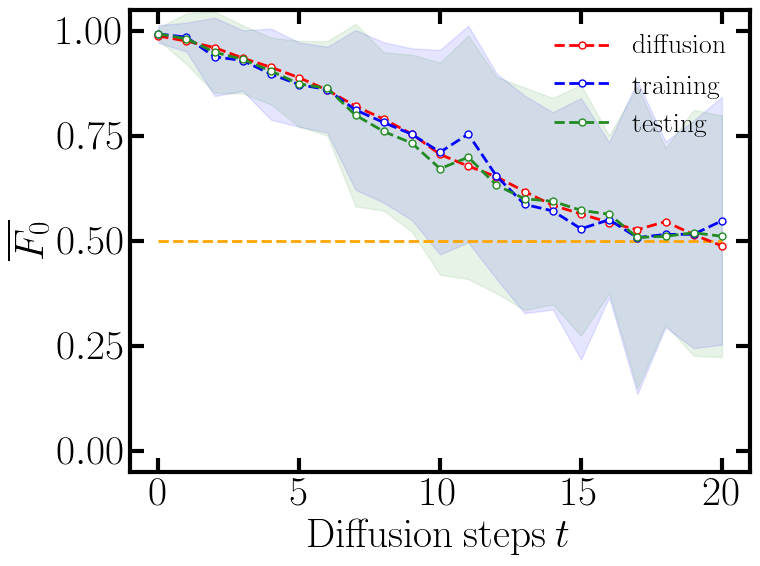

In [11]:
# plot the performance of training
n, na = 1, 1
T = 20
L = 4
Ndata = 100
states_diff = np.load('data/cluster/n1/cluster0Diff_n1T20_N1000.npy')
states_train = np.load('data/cluster/n1/QDDPMcluster0trainGen_n1na1T20L4_mmd.npy')
states_test = np.load('data/cluster/n1/QDDPMcluster0testGen_n1na1T20L4_mmd.npy')

F0_train = np.abs(states_train[:, :, 0])**2
F0_test = np.abs(states_test[:, :, 0])**2
F0_diff = np.abs(states_diff[:, :, 0])**2

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(range(T+1), np.mean(F0_diff, axis=1), 'o--', markersize=5, mfc='white', lw=2, c='r', 
            zorder=5, label=r'$\rm diffusion$')
ax.plot(range(T+1), 0.5*np.ones(T+1), '--', lw=2, c='orange')

ax.plot(range(T+1), np.mean(F0_train, axis=1), 'o--', markersize=5, mfc='white', lw=2, c='b', 
            zorder=5, label=r'$\rm training$')
ax.fill_between(range(T+1), np.mean(F0_train, axis=1)-np.std(F0_train, axis=1), 
                    np.mean(F0_train, axis=1)+np.std(F0_train, axis=1), color='b', alpha=0.1)

ax.plot(range(T+1), np.mean(F0_test, axis=1), 'o--', markersize=5, mfc='white', lw=2, c='forestgreen', 
            zorder=5, label=r'$\rm testing$')
ax.fill_between(range(T+1), np.mean(F0_test, axis=1)-np.std(F0_test, axis=1), 
                    np.mean(F0_test, axis=1)+np.std(F0_test, axis=1), color='forestgreen', alpha=0.1)

ax.legend(fontsize=20, framealpha=0)
ax.set_ylim(-0.05, 1.05)
ax.set_xticks(np.arange(0, T+1, 5))
ax.set_xlabel(r'${\rm Diffusion\:steps}\:t$', fontsize=30)
ax.set_ylabel(r'$\overline{F_0}$', fontsize=30)
ax.tick_params(direction='in', length=10, width=3, top='on', right='on', labelsize=30)

plt.show()
plt.close()

### Visulize the performance in MMD

In [14]:
# calculate MMD
X = torch.from_numpy(np.load('data/cluster/n1/cluster0Diff_n1T20_N1000.npy'))
X_train = torch.from_numpy(np.load('data/cluster/n1/QDDPMcluster0trainGen_n1na1T20L4_mmd.npy'))
X_test = torch.from_numpy(np.load('data/cluster/n1/QDDPMcluster0testGen_n1na1T20L4_mmd.npy'))
X0 = torch.from_numpy(cluster0Gen(1, 1000, 0.08, seed=16))

mmds = np.zeros((3, 21))
for t in range(21):
    idx = np.random.choice(X.shape[1], size=100, replace=False)
    mmds[0, t] = naturalDistance(X0, X[t, idx])
    mmds[1, t] = naturalDistance(X0, X_train[t])
    mmds[2, t] = naturalDistance(X0, X_test[t])
np.save('data/cluster/n1/QDDPMcluster0Genloss_n1na1T20L4_mmd.npy', mmds)

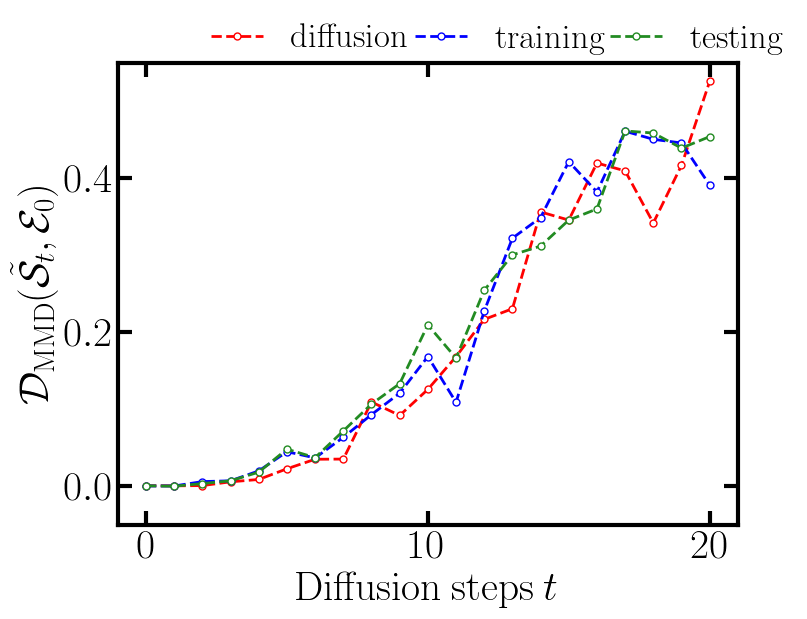

In [35]:
mmds = np.load('data/cluster/n1/QDDPMcluster0Genloss_n1na1T20L4_mmd.npy')

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(mmds[0], 'o--', markersize=5, mfc='white', lw=2, c='r', label=r'$\rm diffusion$')
ax.plot(mmds[1], 'o--', markersize=5, mfc='white', lw=2, c='b', label=r'$\rm training$')
ax.plot(mmds[2], 'o--', markersize=5, mfc='white', lw=2, c='forestgreen', label=r'$\rm testing$')

ax.legend(loc='lower left', bbox_to_anchor=(0.1, 0.95), fontsize=25, framealpha=0, labelspacing=0.4,
          ncol=3, columnspacing=0.2, handlelength=1.5)
ax.set_xlabel(r'${\rm Diffusion\:steps}\:t$', fontsize=30)
ax.set_ylabel(r'$\mathcal{D}_{\rm MMD}(\tilde{\mathcal{S}}_t, \mathcal{E}_0)$', fontsize=30)
ax.set_ylim(-0.05, 0.55)
ax.tick_params(direction='in', length=10, width=3, top='on', right='on', labelsize=30)

### Plot the training history

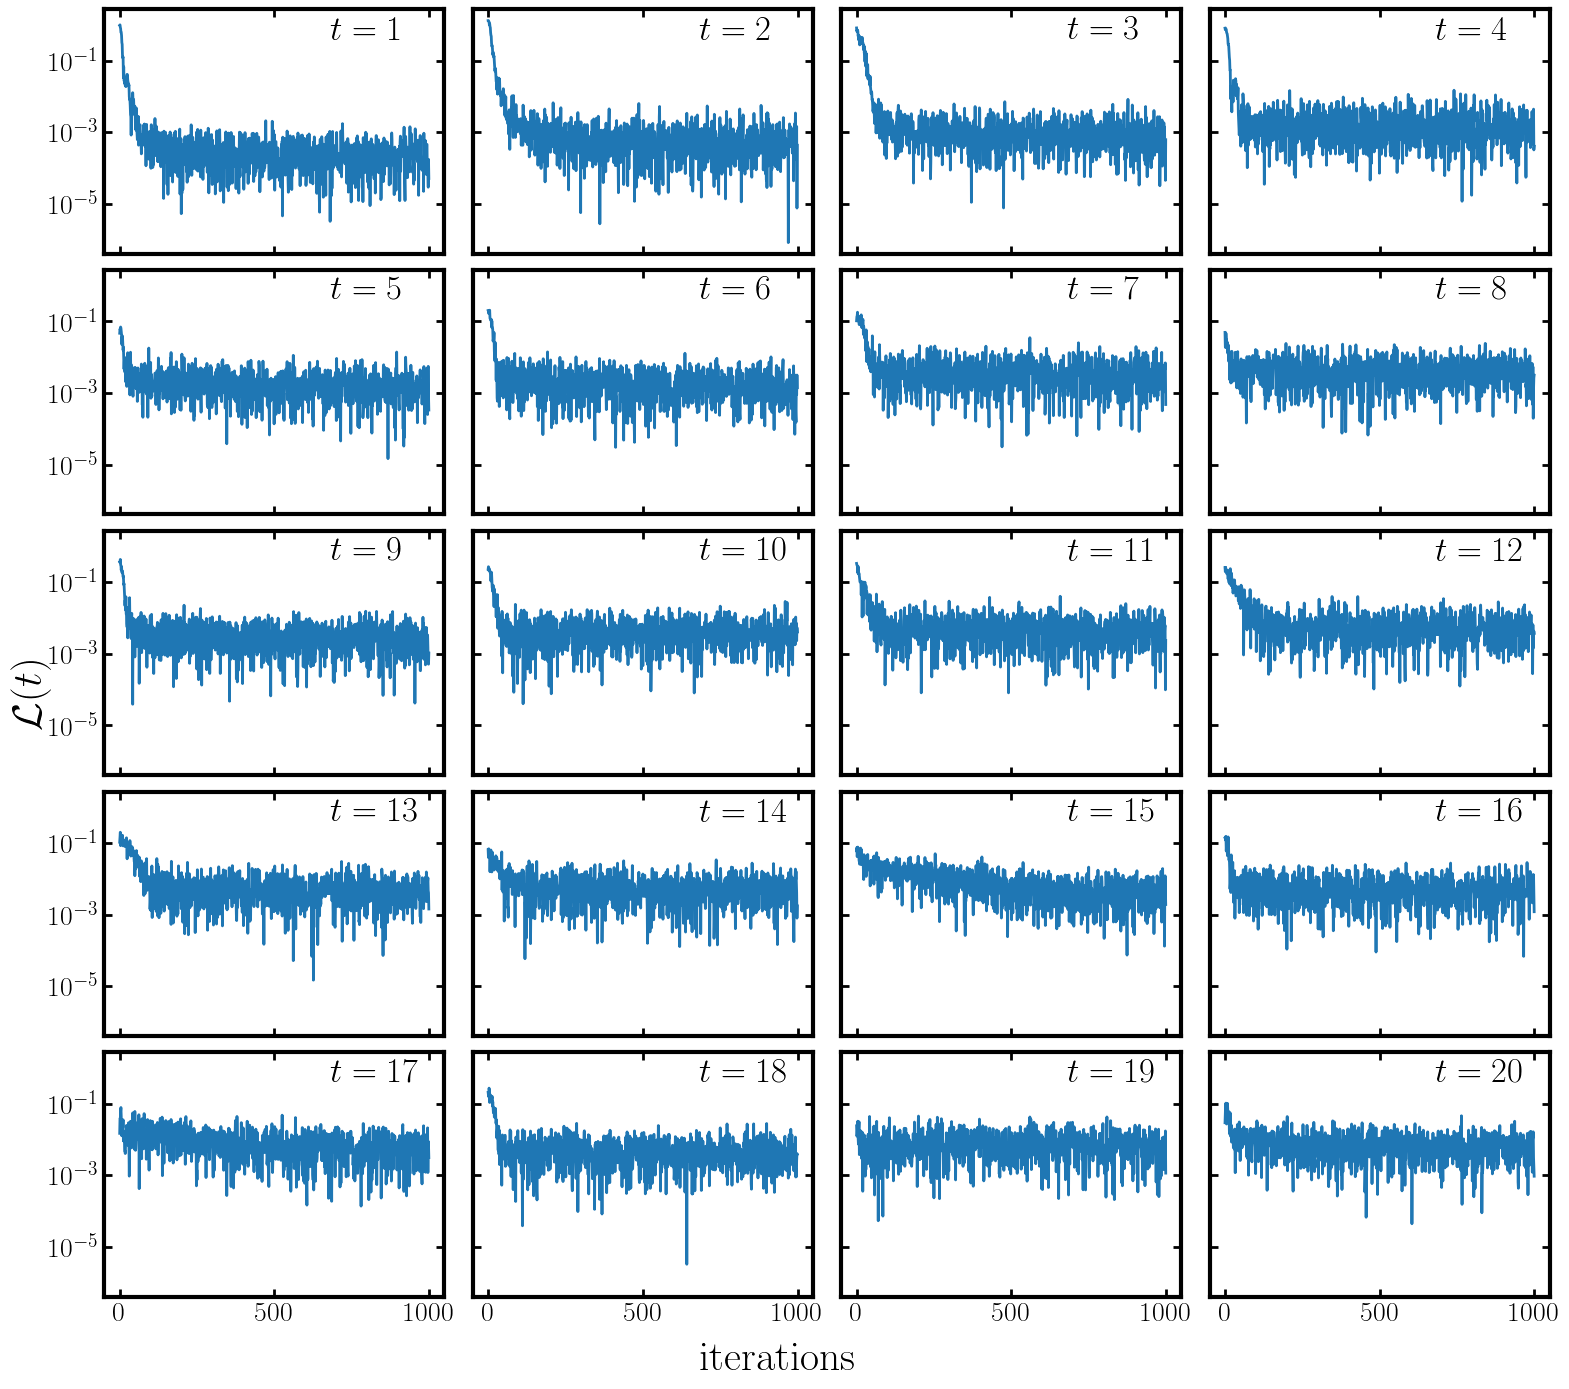

In [16]:
# plot training loss history
n, na = 1, 1
T = 20
L = 4
loss = np.load('data/cluster/n1/QDDPMcluster0loss_n1na1T20L4_mmd.npy')
fig, axs = plt.subplots(5, 4, figsize=(16, 14), sharex=True, sharey=True)
for i in range(20):
    axs[i//4, i%4].plot(loss[i], lw=2)
    axs[i//4, i%4].tick_params(direction='in', length=6, width=2, top='on', right='on', labelsize=20)
    axs[i//4, i%4].text(x=680, y=0.4, s=r'$t=%d$'%(i+1), fontsize=25)
    axs[i//4, i%4].set_yscale('log')
fig.supxlabel(r'$\rm iterations$', fontsize=30)
fig.supylabel(r'$\mathcal{L}(t)$', fontsize=30)
plt.tight_layout()
plt.show()
plt.close()

# 2-qubit cluster problem

## generate diffusion data

In [21]:
# generate diffusion data set
n = 2
T = 20
Ndata = 1000

diff_hs = np.linspace(0.5, 4., T)

model_diff = DiffusionModel(n, T, Ndata)
X = torch.from_numpy(cluster0Gen(2, Ndata, 0.06, seed=12))
Xout = np.zeros((T+1, Ndata, 2**n), dtype=np.complex64)
Xout[0] = X
for t in range(1, T+1):
    Xout[t] = model_diff.set_diffusionData_t(t, X, diff_hs[:t], seed=t).numpy()
np.save('data/cluster/n2/cluster0Diff_n2T20_N%d.npy'%N, Xout)

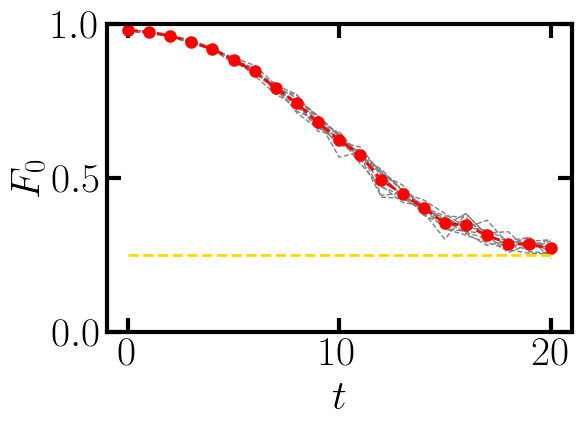

In [22]:
# visualize the fidelity decay in the diffusion process
n = 2
T = 20
Ndata = 1000
states_diff = np.load('data/cluster/n2/cluster0Diff_n2T20_N1000.npy')

fig, ax = plt.subplots(figsize=(6, 4))
indices = np.random.permutation(1000)
for i in range(10):
    ax.plot(range(T+1), np.mean(np.abs(states_diff[:, indices[100*i:100*(i+1)], 0])**2, axis=1),
            '--', lw=1, c='grey')
ax.plot(range(T+1), np.mean(np.abs(states_diff[:,:,0])**2, axis=1), 'o--', markersize=8, lw=2, c='r')
ax.plot(range(T+1), 0.25*np.ones(T+1), '--', lw=2, c='gold')
ax.set_ylabel(r'$F_0$', fontsize=30)
ax.set_xlabel(r'$t$', fontsize=30)
ax.set_ylim(0,1)
ax.tick_params(direction='in', length=10, width=3, top='on', right='on', labelsize=30)

## Training

In [ ]:
# Training
n, na = 2, 1 # number of data and ancilla qubits
T = 20 # number of diffusion steps
L = 6 # layer of backward PQC
Ndata = 100 # number of data in the training data set
epochs = 2001 # number of training epochs

# generate random samples at step t=T
diffModel = DiffusionModel(n, T, Ndata)
inputs_T = diffModel.HaarSampleGeneration(Ndata, seed=22)

# load diffusion process
states_diff = np.load('data/cluster/n2/cluster0Diff_n2T20_N1000.npy')

model = QDDPM(n=n, na=na, T=T, L=L)
model.set_diffusionSet(states_diff)

for t in range(T-1, -1, -1):
    params_tot = np.zeros((T, 2*(n+na)*L))
    for tt in range(t+1, 20):
        params_tot[tt] = np.load('data/cluster0/n2/QDDPMcluster0params_n2na1T20L6_t%d_mmd.npy'%tt)
    params, loss_hist = Training_t(model, t, inputs_T, params_tot, Ndata, epochs)

    np.save('data/cluster/n2/QDDPMcluster0params_n2na1T20L6_t%d_mmd.npy'%t, params.numpy())
    np.save('data/cluster/n2/QDDPMcluster0loss_n2na1T20L6_t%d_mmd.npy'%t, loss_hist.numpy())

## Performance

### Generate training and testing data

In [4]:
# collect trainining result
n, na = 2, 1
T = 20
L = 6
Ndata = 100
epochs = 2000

params_tot = np.zeros((T, 2*(n+na)*L))
loss_tot = np.zeros((T, epochs))
f0_tot = np.zeros((T, epochs))

for t in range(T):
    params_tot[t] = np.load('data/cluster0/n2/QDDPMcluster0params_n2na1T20L6_t%d_mmd.npy'%t)
    loss_tot[t] = np.load('data/cluster0/n2/QDDPMcluster0loss_n2na1T20L6_t%d_mmd.npy'%t)
    
np.save('data/cluster0/n2/QDDPMcluster0params_n2na1T20L6_mmd.npy', params_tot)
np.save('data/cluster0/n2/QDDPMcluster0loss_n2na1T20L6_mmd.npy', loss_tot)

In [74]:
# generate training & test data
n, na = 2, 1
T = 20
L = 6
Ndata = 100

params_tot = np.load('data/cluster0/n2/QDDPMcluster0params_n2na1T20L6_nat.npy')

diffModel = DiffusionModel(n, T, Ndata)
inputs_T_tr = diffModel.HaarSampleGeneration(Ndata, seed=22)
inputs_T_te = diffModel.HaarSampleGeneration(Ndata, seed=23)


model = QDDPM(n=n, na=na, T=T, L=L)

data_tr = model.backDataGeneration(inputs_T_tr, params_tot, Ndata)[:, :, :2**n].numpy()
data_te = model.backDataGeneration(inputs_T_te, params_tot, Ndata)[:, :, :2**n].numpy()

np.save('data/cluster/n2/QDDPMcluster0trainGen_n2na1T20L6_mmd.npy', data_tr)
np.save('data/cluster/n2/QDDPMcluster0testGen_n2na1T20L6_mmd.npy', data_te)

### Visualize in fidelity

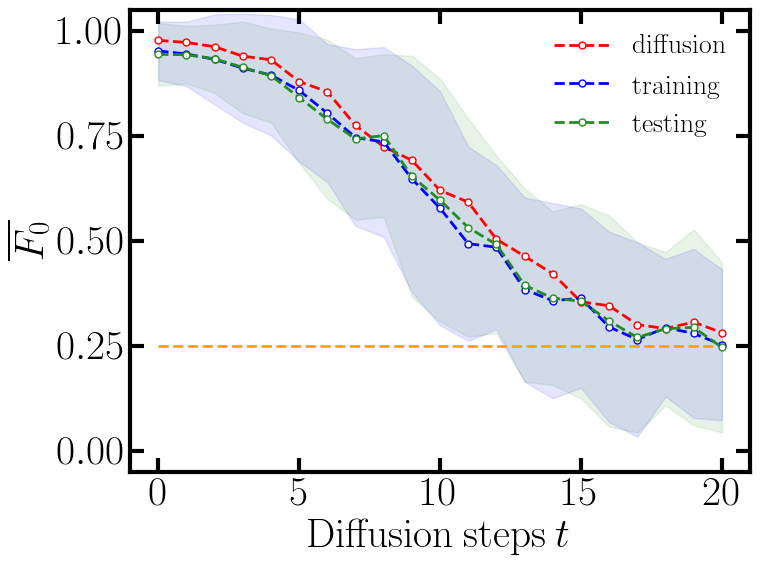

In [31]:
# plot the performance of training
n, na = 2, 1
T = 20
L = 6
Ndata = 100
states_diff = np.load('data/cluster/n2/cluster0Diff_n2T20_N1000.npy')
states_train = np.load('data/cluster/n2/QDDPMcluster0trainGen_n2na1T20L6_mmd.npy')
states_test = np.load('data/cluster/n2/QDDPMcluster0testGen_n2na1T20L6_mmd.npy')

F0_train = np.abs(states_train[:, :, 0])**2
F0_test = np.abs(states_test[:, :, 0])**2
F0_diff = np.abs(states_diff[:, :Ndata, 0])**2

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(range(T+1), np.mean(F0_diff, axis=1), 'o--', markersize=5, mfc='white', lw=2, c='r', 
            zorder=5, label=r'$\rm diffusion$')
ax.plot(range(T+1), 0.25*np.ones(T+1), '--', lw=2, c='orange')

ax.plot(range(T+1), np.mean(F0_train, axis=1), 'o--', markersize=5, mfc='white', lw=2, c='b', 
            zorder=5, label=r'$\rm training$')
ax.fill_between(range(T+1), np.mean(F0_train, axis=1)-np.std(F0_train, axis=1), 
                    np.mean(F0_train, axis=1)+np.std(F0_train, axis=1), color='b', alpha=0.1)

ax.plot(range(T+1), np.mean(F0_test, axis=1), 'o--', markersize=5, mfc='white', lw=2, c='forestgreen', 
            zorder=5, label=r'$\rm testing$')
ax.fill_between(range(T+1), np.mean(F0_test, axis=1)-np.std(F0_test, axis=1), 
                    np.mean(F0_test, axis=1)+np.std(F0_test, axis=1), color='forestgreen', alpha=0.1)

ax.legend(fontsize=20, framealpha=0)
ax.set_ylim(-0.05, 1.05)
ax.set_xticks(np.arange(0, T+1, 5))
ax.set_xlabel(r'${\rm Diffusion\:steps}\:t$', fontsize=30)
ax.set_ylabel(r'$\overline{F_0}$', fontsize=30)
ax.tick_params(direction='in', length=10, width=3, top='on', right='on', labelsize=30)

### visualize in MMD

In [ ]:
# calculate MMD
X = torch.from_numpy(np.load('data/cluster/n2/cluster0Diff_n2T20_N1000.npy'))
X_train = torch.from_numpy(np.load('data/cluster/n2/QDDPMcluster0trainGen_n2na1T20L6_mmd.npy'))
X_test = torch.from_numpy(np.load('data/cluster/n2/QDDPMcluster0testGen_n2na1T20L6_mmd.npy'))
X0 = torch.from_numpy(cluster0Gen(2, 1000, 0.06, seed=16))

mmds = np.zeros((3, 21))
for t in range(21):
    idx = np.random.choice(X.shape[1], size=100, replace=False)
    mmds[0, t] = naturalDistance(X0, X[t, idx])
    mmds[1, t] = naturalDistance(X0, X_train[t])
    mmds[2, t] = naturalDistance(X0, X_test[t])
np.save('data/cluster/n2/QDDPMcluster0Genloss_n2na1T20L6_mmd.npy', mmds)

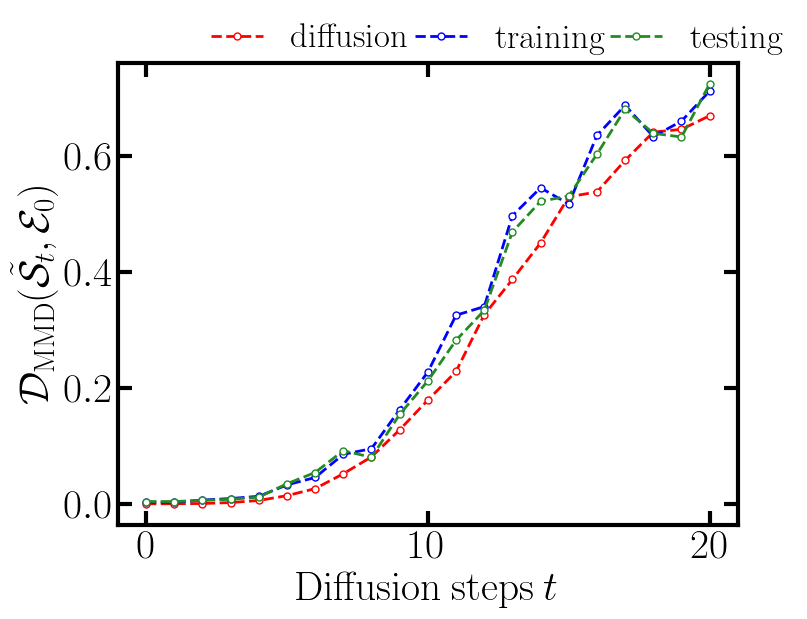

In [34]:
mmds = np.load('data/cluster/n2/QDDPMcluster0Genloss_n2na1T20L6_mmd.npy')

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(mmds[0], 'o--', markersize=5, mfc='white', lw=2, c='r', label=r'$\rm diffusion$')
ax.plot(mmds[1], 'o--', markersize=5, mfc='white', lw=2, c='b', label=r'$\rm training$')
ax.plot(mmds[2], 'o--', markersize=5, mfc='white', lw=2, c='forestgreen', label=r'$\rm testing$')

ax.legend(loc='lower left', bbox_to_anchor=(0.1, 0.95), fontsize=25, framealpha=0, labelspacing=0.4,
          ncol=3, columnspacing=0.2, handlelength=1.5)
ax.set_xlabel(r'${\rm Diffusion\:steps}\:t$', fontsize=30)
ax.set_ylabel(r'$\mathcal{D}_{\rm MMD}(\tilde{\mathcal{S}}_t, \mathcal{E}_0)$', fontsize=30)
ax.tick_params(direction='in', length=10, width=3, top='on', right='on', labelsize=30)

### Plot training history

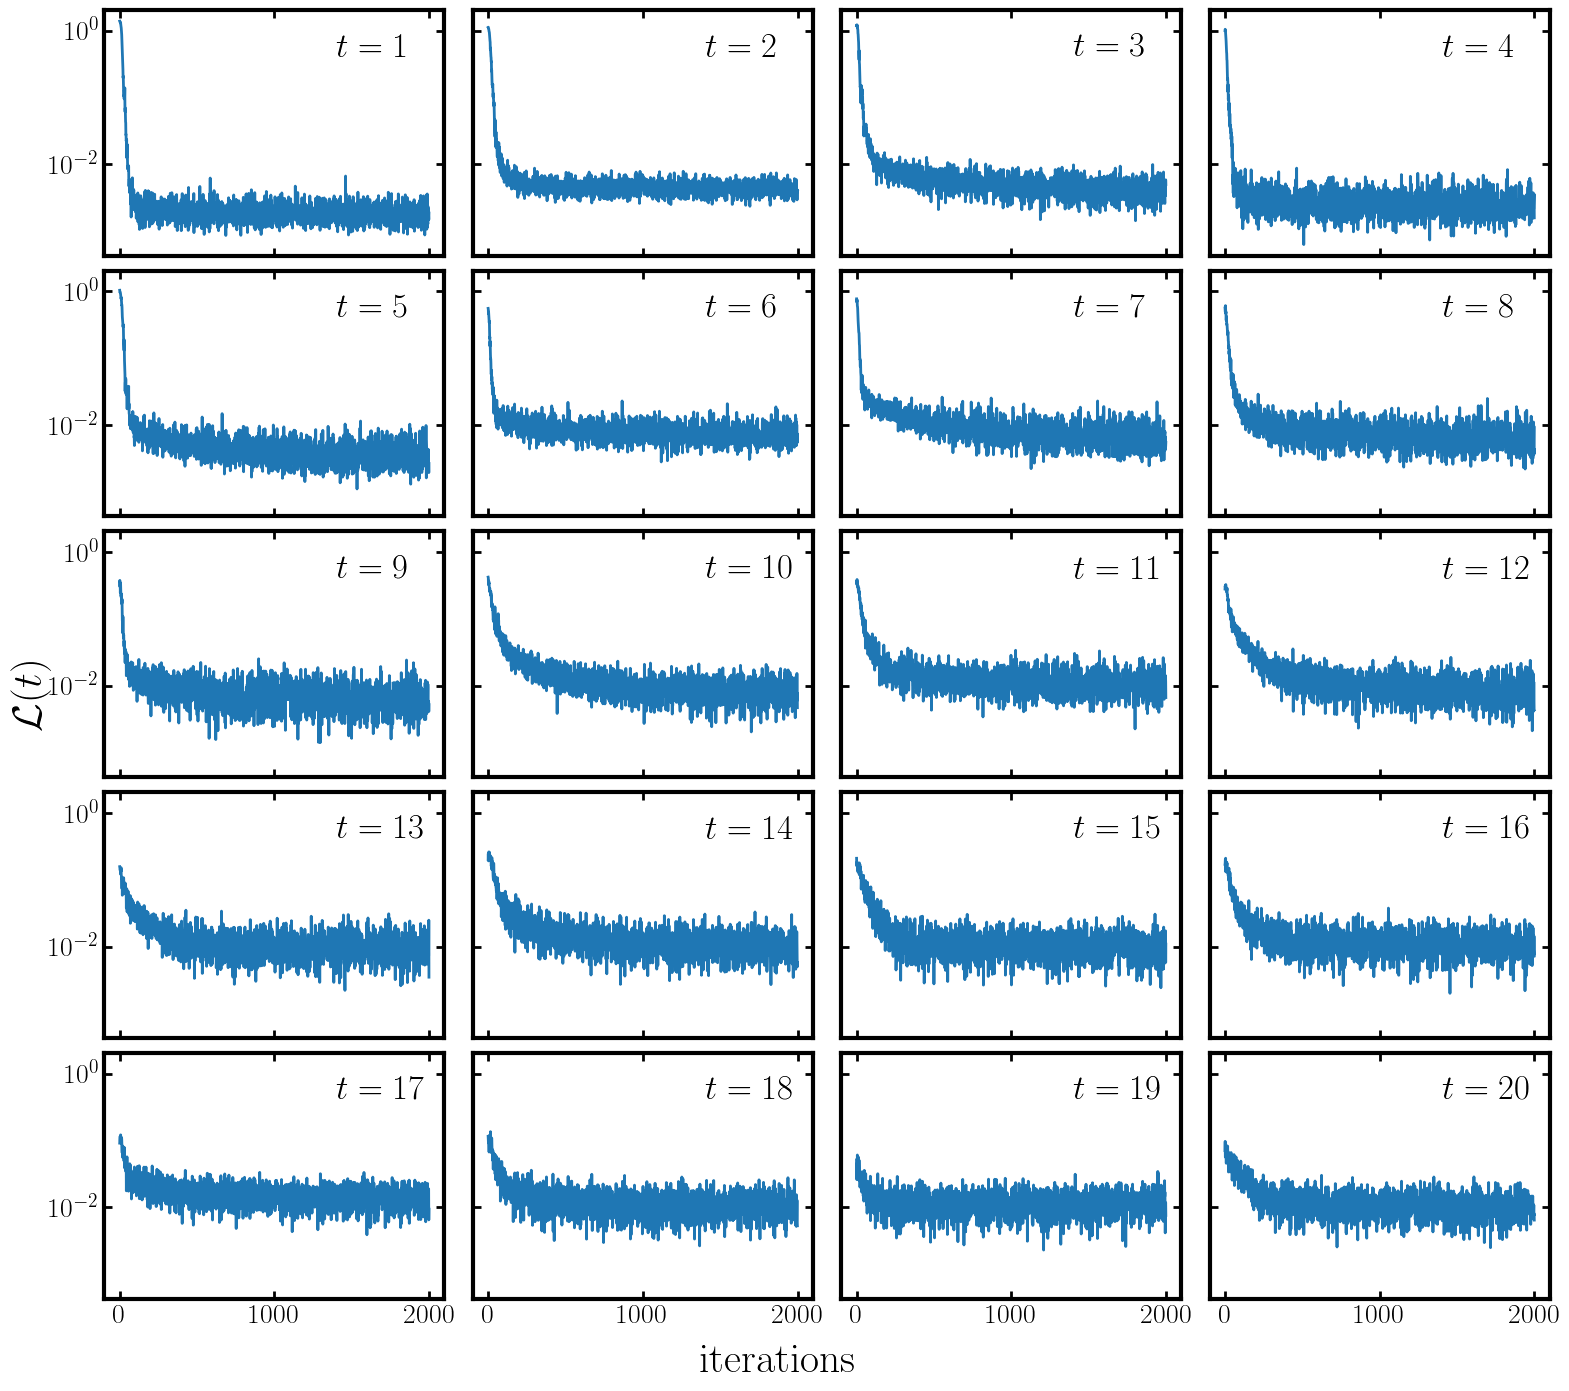

In [36]:
# plot training loss history
n, na = 2, 1
T = 20
L = 6
loss = np.load('data/cluster/n2/QDDPMcluster0loss_n2na1T20L6_mmd.npy')
fig, axs = plt.subplots(5, 4, figsize=(16, 14), sharex=True, sharey=True)
for i in range(20):
    axs[i//4, i%4].plot(loss[i], lw=2)
    axs[i//4, i%4].tick_params(direction='in', length=6, width=2, top='on', right='on', labelsize=20)
    axs[i//4, i%4].text(x=1400, y=0.4, s=r'$t=%d$'%(i+1), fontsize=25)
    axs[i//4, i%4].set_yscale('log')
fig.supxlabel(r'$\rm iterations$', fontsize=30)
fig.supylabel(r'$\mathcal{L}(t)$', fontsize=30)
plt.tight_layout()

In [4]:
np.mean(F0_diff[:, 0], axis=1), np.std(F0_diff[:, 0], axis=1),\
np.mean(F0_train[:, 0], axis=1), np.std(F0_train[:, 0], axis=1),\
np.mean(F0_test[:, 0], axis=1), np.std(F0_test[:, 0], axis=1)

(array([0.98659067, 0.9772121 ]),
 array([0.01315122, 0.01423472]),
 array([0.99245266, 0.95194567]),
 array([0.02084307, 0.06973477]),
 array([0.99284238, 0.94383771]),
 array([0.01422329, 0.07477042]))